# Classifying the HTRC Genre Word Frequencies

This notebook is a part of work being done for the [Trace of Theory project](https://github.com/htrc/ACS-TT), a collaboration between researchers of [NovelTM](http://novel-tm.ca/) and the HathiTrust Research Center ([HTRC](https://www.hathitrust.org/)). In particular, we are wanting to use both [supervised](https://en.wikipedia.org/wiki/Supervised_learning) and [unsupervised](https://en.wikipedia.org/wiki/Unsupervised_learning) machine learning techniques on HTRC texts to gain a better understanding of the extent and nature of theory in various genres.

This notebook builds on the [Classifying Philosophical Texts](ClassifyingPhilosophicalText.ipynb) notebook where we looked at building a classifier for philosophical texts, based on a small training corpus. In this notebook we'll try to use a trained classifier to identify philosophical texts based on [genre-specific wordcounts for 178,381 volumes from the HathiTrust Digital Library](https://sharc.hathitrust.org/genre); the genres are fiction, drama and poetry.

## Building a Philosophical Classifier

The first step is to (re)build our [philosophical classifier](ClassifyingPhilosophicalText.ipynb). It's worth reiterating that the classifier is being trained on a relatively small corpus (so isn't likely as representative as it might be) and that the new HTRC genre corpus is literature-specific (so a different kind of beast from our training corpus). Is it still useful as a classifier? that's part of what we'd like to find out.

The classifier created below is essentially the [same](ClassifyingPhilosophicalText.ipynb) as before, though we'll use the [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) algorithm because it provides a way of not just classifying (philosophical or non-philosophical) but also of expressing a value for how philosophical or not the text is.

In [14]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# define the training corpus to use (while filtering out our Philosohpical ouliers)
philo_data_dir = "C:/Users/broomgrass/iPython/HathiTrust/ACS-TT-master/ACS-TT-master/data/philosophy"
philo_corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(philo_data_dir+"/texts", ".*\.txt")
filtered_fileids = [fileid for fileid in philo_corpus.fileids() if "GameOfLogic" not in fileid and "ThusSpakeZarathustr" not in fileid]

# create TF-IDF (actually elative frequencies) vectorizer
stopword_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)
X_train = stopword_vectorizer.fit_transform([philo_corpus.raw(fileid) for fileid in filtered_fileids])
philo_categories = ["Philosophy" if "Philosophy" in fileid else "Other" for fileid in filtered_fileids]

# create a classiier
philo_clf = LinearSVC(loss='l2', penalty="l2", dual=False, tol=1e-3)
philo_clf.fit(X_train, philo_categories)

C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)

## Analyzing the HTRC Genre Corpus

The HTRC Genre corpus is organized by genre (if you rsync the directory rather than just download the files from the web the files are organized into subfolders by genre). For each genre there's a metadata file with all the volumes for that genre and then a set of compressed archives (.tar.gz) organized by time slice. Our strategy here will be as follows:

* for each genre folder (fiction, drama, poetery)
    * read the metadata file into a table
    * for each compressed archive in the genre folder (*.tar.gz)
        * for each tab-separated values file in the archive
            * create a pseudo text 
            * for each word-count pair: add the word the specified number of times to our pseuedo text
            * produce a classifier decision (a value how philosophical the text is
            * add the prediction value to the corresponding row in the metadata table

In [8]:
from os import walk
import pandas as pd
from os.path import join
import glob

def get_genre_metadata_and_predictions(genre_dir, clf, vectorizer):
    metadatas = {}
    for (dirpath, dirnames, filenames) in walk(htrc_genre_dir):
        for genre in dirnames:
            genre_path = join(htrc_genre_dir, genre) 
            metadata = pd.read_csv(join(genre_path, genre+"_metadata.csv"), index_col=0)
            metadata['prediction'] = [float(0)] * len(metadata)
            for tgz in glob.glob(join(genre_path,"*.tar.gz")):
                print("Analyzing "+tgz)
                tar = tarfile.open(tgz, "r:gz")
                for tarinfo in tar:
                    if tarinfo.isreg() and tarinfo.name.endswith("tsv"):

                        # read in the TSV file and expand the text (it would probably be quicker to
                        # create a vectorizer that can use the feature counts directly, but oh well
                        text = ""
                        tsv = tar.extractfile(tarinfo)
                        for line in tsv.readlines():
                            word, count = line.decode("utf-8").strip().split("\t")
                            if any(c for c in word if c.isalpha()):
                                text += (word + " ") * int(count)

                        # predict the class
                        X_test = vectorizer.transform([text])
                        metadata['prediction'][tarinfo.name[0:-4]] = clf.decision_function(X_test)[0]

                tar.close()
            metadatas[genre] = metadata.sort('prediction', ascending=False)
        break
    return metadatas

Now we should be ready to use our classifier on the HTRC Genre corpus. This returns a dictionary object with keys for each genre (fiction, drama, poetry) and values that are pandas dataframes with all the existing metadata for each volume, plus the philosophical prediction that we've added.

In [9]:
htrc_genre_dir = "C:/Users/broomgrass/iPython/HathiTrust/data"
philo_metadatas = get_genre_metadata_and_predictions(htrc_genre_dir, philo_clf, stopword_vectorizer)

We can have a quick peek to see how many volumes are contained in each genre:

In [10]:
total = 0
for genre, metadata in philo_metadatas.items():
    total += len(metadata.index)
    print(genre+": "+"{:,}".format(len(metadata.index)))
print("total: "+"{:,}".format(total))


total: 0


## Listing Most Philosophical Texts

Ok, so let's rub our hands together in anticipation and have a closer look at the predictions. For each genre, let's enumerate the 15 most philosophical texts (i.e. the texts that were assigned the highest values by our philosophical classifier).

In [11]:
for genre, metadata in philo_metadatas.items():
    print(genre)
    for name, row in metadata.head(15).iterrows():
        print("  "+str(row['prediction']) + ": " + str(row["author"]) + " " + str(row["title"])[:40] + " ("+ name+")")

One of the things this exposes immediately is that the HTRC genre feature sets contain duplicate texts (presumably because of sampling from different libraries – these aren't identifical files since they're the product of separated digitization and possibly separate editions). This is an annoyance, though we can probably just skip through duplicates in looking at the top samples from each group.

Another noticeable thing is the set of 0.0 scores with drama. That score is likely because no prediction was made for the particular text, for some reason. But more importantly, it means that we don't dig very deep in the drama corpus before reaching texts that have negative scores (or zero), which means that the corpus as a whole appears to be less philosohpical. 

## Plotting by Year

Because our volumes metadata contains date/year values, we can plot the philosophical predictions by year for each genre, this might give us a sense of some diachronic trends, how things change over time.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

for genre, metadata in philo_metadatas.items():
    metadata.plot(kind='scatter', x='date', y='prediction', label=genre)

The clearest thing from these graphs is that all three genres show more variability over time. This is no doubt in part because there are more texts per year as we move forward in time, but that doesn't fully explain the larger discrepencies in scores – it would see that some texts are getting more philosophical while some texts are getting less philosohpical.

We also see here a confirmation of our observation earlier about drama being less philosophical, we can eyeball that most scores are under zero. We can observe a crevasse around 1900 in drama, and an even more pronounced gap in poetery at about the same time. This may be caused by an issue with the [HTRC genre feature sets](https://sharc.hathitrust.org/genre) where poetry_1894-1899.tar.gz and drama_1880-1884.tar.gz are empty.

## Plotting Means by Year

Plotting all 178,381 points makes for very dense scatterplots. Another way to look at change over time is to consider the annual mean philosophical value for each genre. In other words, we look at the average of all the classifier predictions by year, and then comapre by genre.

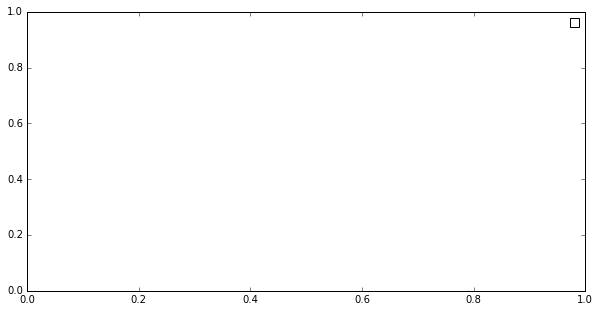

In [13]:
plt.figure(figsize=(10,5))
for genre, metadata in philo_metadatas.items():
    values = {}
    for key, grp in metadata.groupby(['date']):
        values[key] = grp['prediction'].mean()
    plt.plot(list(values.keys()), list(values.values()), label=genre)
plt.legend(philo_metadatas.keys())
plt.show()

The first century or so shows more fluctuation erratic than the rest (possibly because there are fewer texts sampled). We see the same weirdness (though even clearer here) with drama and poetry that we noticed in the previous plots. Most genres have a graduate drop in philosophically classified texts, with the possible exception of drama.

## Summary and Next Steps

Even though our philosophical classifier was created with a relatively small and heterogeneous corpus, it seems useful in trying to identify philosophical texts in the HTRC Genre corpus, as well as suggesting some possible insights about genre and changes over time. In particular:

* the HTRC Genre corpus has a lot of duplicate texts
* the HTRC Genre corpus increases the number of volumes per year over time
* there's an issue with the HTRC Genre corpus around the end of the 19th century
* philosophical variation seems to increase over time
* drama is the least philosohpical genre
* fiction and poetry seem to get less philosophical over time

It might be interesting to run the same experiment with the [LitCrit classifier](ClassifyingLitCrit.ipynb).

The HTRC Genre corpus is a wonderful resource because it provides well-organized and readily-accessible word frequency values. The next step might be to try something similar on the full HTRC corpus of 4.8 volumes (though likely a subset of that since our classifier has been trained for English texts only).

---

(CC-BY) By Stéfan Sinclair, Geoffrey Rockwell and the [Trace of Theory team](https://github.com/htrc/ACS-TT), last updated November 16, 2015.